In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def preprocess_data(file_path, model_type):
    """
    Preprocess the data based on the model type.
    
    Args:
        file_path (str): Path to the dataset file.
        model_type (str): Model type ("RF", "SVM", "ANN").
    
    Returns:
        X, y, X_train, X_test, y_train, y_test: Processed features and labels, split into training and testing sets.
    """
    # Read data
    df = pd.read_csv(file_path)
    
    # Handle missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_imputed = imputer.fit_transform(df.drop(['quality'], axis=1))
    y = df['quality']
    
    # Feature normalization
    scaler = StandardScaler()
    X = scaler.fit_transform(X_imputed)
    
    if model_type == "ANN":
        # One-hot encode the labels for ANN
        y = to_categorical(y)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    return X, y, X_train, X_test, y_train, y_test

In [2]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
import json

def hyperparameter_tuning(X_train, y_train, model_type, result_file):
    """
    Perform hyperparameter tuning based on the model type.
    
    Args:
        X_train (np.array): Training features.
        y_train (np.array): Training labels.
        model_type (str): Type of model ("RF", "SVM", "ANN").
    
    Returns:
        best_model (model object): Best model found through GridSearchCV.
        best_params (dict): Dictionary of the best parameters.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    if model_type == "RF":
        params = {
            'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
            'max_depth': [None, 10, 20, 30, 40, 50],
            'min_samples_split': [2, 5, 10]
        }
        model = RandomForestClassifier(random_state=42)
    
    elif model_type == "SVM":
        params = {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto', 0.1, 1]
        }
        model = SVC(random_state=42)
    
    elif model_type == "ANN":
        params = {
            'neurons': [16, 32, 64],
            'layers': [1, 2, 3],
            'epochs': [50, 100, 150],
            'batch_size': [10, 20, 30]
        }
        
        # model = KerasClassifier(build_fn=lambda: create_model(neurons=16, layers=1), verbose=0)
        model = KerasClassifier(build_fn=lambda neurons, layers: create_model(neurons=neurons, layers=layers, input_shape=X_train.shape[1], num_classes=len(np.unique(y_train))), verbose=0)


    grid_search = GridSearchCV(model, params, cv=kf, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Save the best model
    joblib.dump(best_model, f'{model_type}_best_model_{result_file}.pkl')
    
    # Save the grid search results
    results = grid_search.cv_results_
    # Convert NumPy arrays in results to lists for JSON serialization
    for key in results.keys():
        if isinstance(results[key], np.ndarray):
            results[key] = results[key].tolist()

    with open(f'{model_type}_cv_results_{result_file}.json', 'w') as f:
        json.dump(results, f)
    
    # Save the best parameters to a txt file
    with open(f'{model_type}_best_params_{result_file}.txt', 'w') as f:
        f.write(json.dumps(best_params))
    
    return best_model, best_params

def create_model(neurons, layers, input_shape=11, num_classes=10):
    """
    Function to create and compile a neural network model.
    
    Args:
        neurons (int): Number of neurons in each hidden layer.
        layers (int): Number of hidden layers.
        input_shape (int): The number of features in the training data.
        num_classes (int): The number of classes in the target labels.
    
    Returns:
        model (Keras model): Compiled neural network model.
    """
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_shape, activation='relu'))
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [3]:
import matplotlib.pyplot as plt
import json

def visualize_results(model_type, result_file):
    """
    Load GridSearchCV results from a file and visualize the hyperparameter tuning performance.
    
    Args:
        model_type (str): Model type ("RF", "SVM", "ANN") used for identifying the result file.
    """
    with open(f'{model_type}_cv_results_{result_file}.json', 'r') as f:
        results = json.load(f)
    
    mean_test_scores = results['mean_test_score']
    params = [str(p) for p in results['params']]
    
    plt.figure(figsize=(35, 6))
    plt.plot(params, mean_test_scores, marker='o')
    plt.title(f'Hyperparameter Tuning Results for {model_type}')
    plt.xlabel('Parameters')
    plt.ylabel('Mean Test Score')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

In [4]:
import time
from sklearn.metrics import accuracy_score
import joblib

def test_model(X_train, y_train, X_test, y_test, model_type, result_file):
    """
    Load the best model parameters from a file, construct the model, and test its performance.
    
    Args:
        X_train, y_train, X_test, y_test (np.array): Training and testing data sets.
        model_type (str): Model type ("RF", "SVM", "ANN").
    
    Returns:
        test_accuracy (float): Accuracy on the test set.
    """
    # Load the best model
    model = joblib.load(f'{model_type}_best_model_{result_file}.pkl')
    
    # Train the model and calculate the training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.4f} seconds.")
    
    # Evaluate on training data
    y_pred_train = model.predict(X_train)
    training_accuracy = accuracy_score(y_train, y_pred_train)
    print(f"Training Accuracy: {training_accuracy:.4f}")
    
    # Evaluate on testing data
    start_time = time.time()
    y_pred_test = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    return test_accuracy

In [5]:
def full_process(file_path, model_type, result_file):
    """
    Run the full process from data preprocessing to model testing and results visualization.
    
    Args:
        file_path (str): Path to the dataset file.
        model_type (str): Model type ("RF", "SVM", "ANN").
    """
    # Data preprocessing
    X, y, X_train, X_test, y_train, y_test = preprocess_data(file_path, model_type)
    
    # Hyperparameter tuning
    best_model, best_params = hyperparameter_tuning(X_train, y_train, model_type, result_file)
    print(f"Best parameters found: {best_params}")
    
    # Visualize results
    visualize_results(model_type, result_file)
    
    # Test the model
    test_accuracy = test_model(X_train, y_train, X_test, y_test, model_type, result_file)
    print(f"Final test accuracy: {test_accuracy:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


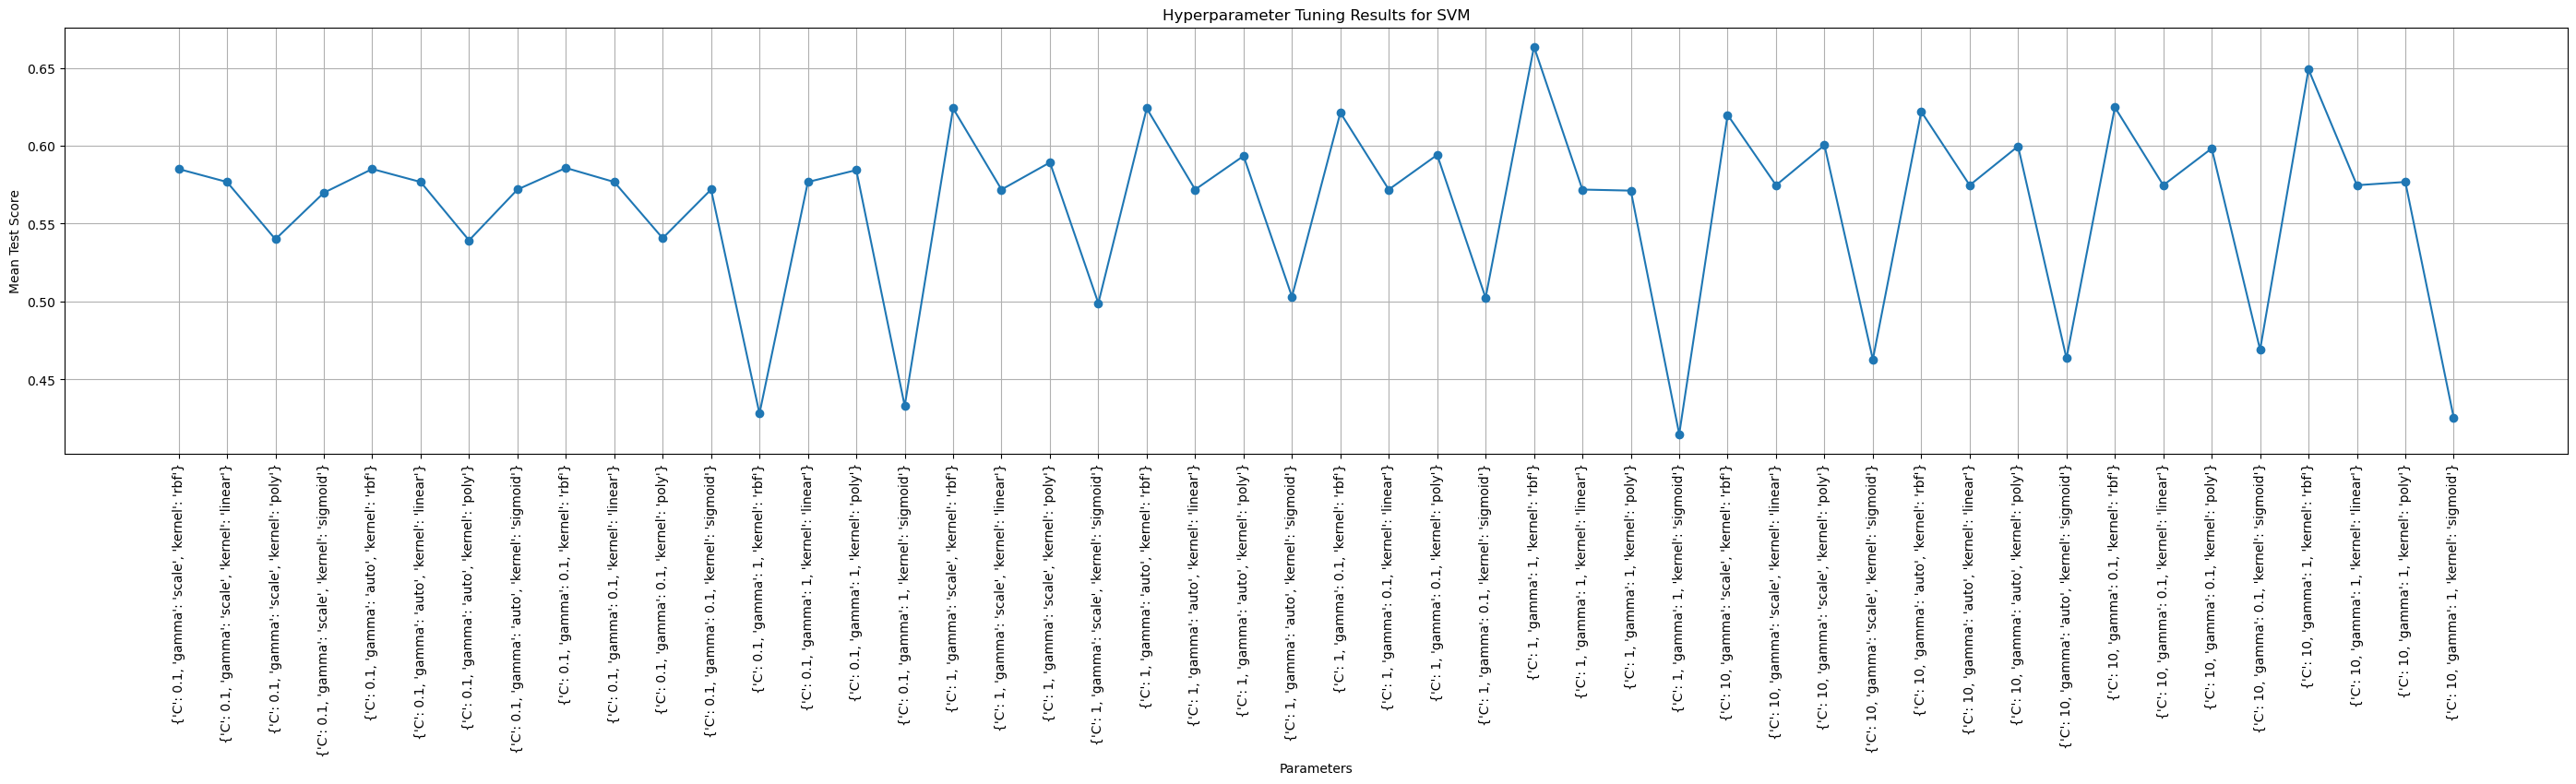

Training completed in 0.1315 seconds.
Training Accuracy: 0.9361
Test Accuracy: 0.6562
Final test accuracy: 0.6562


In [6]:
full_process('processed_wine_quality.csv', 'SVM','origin')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


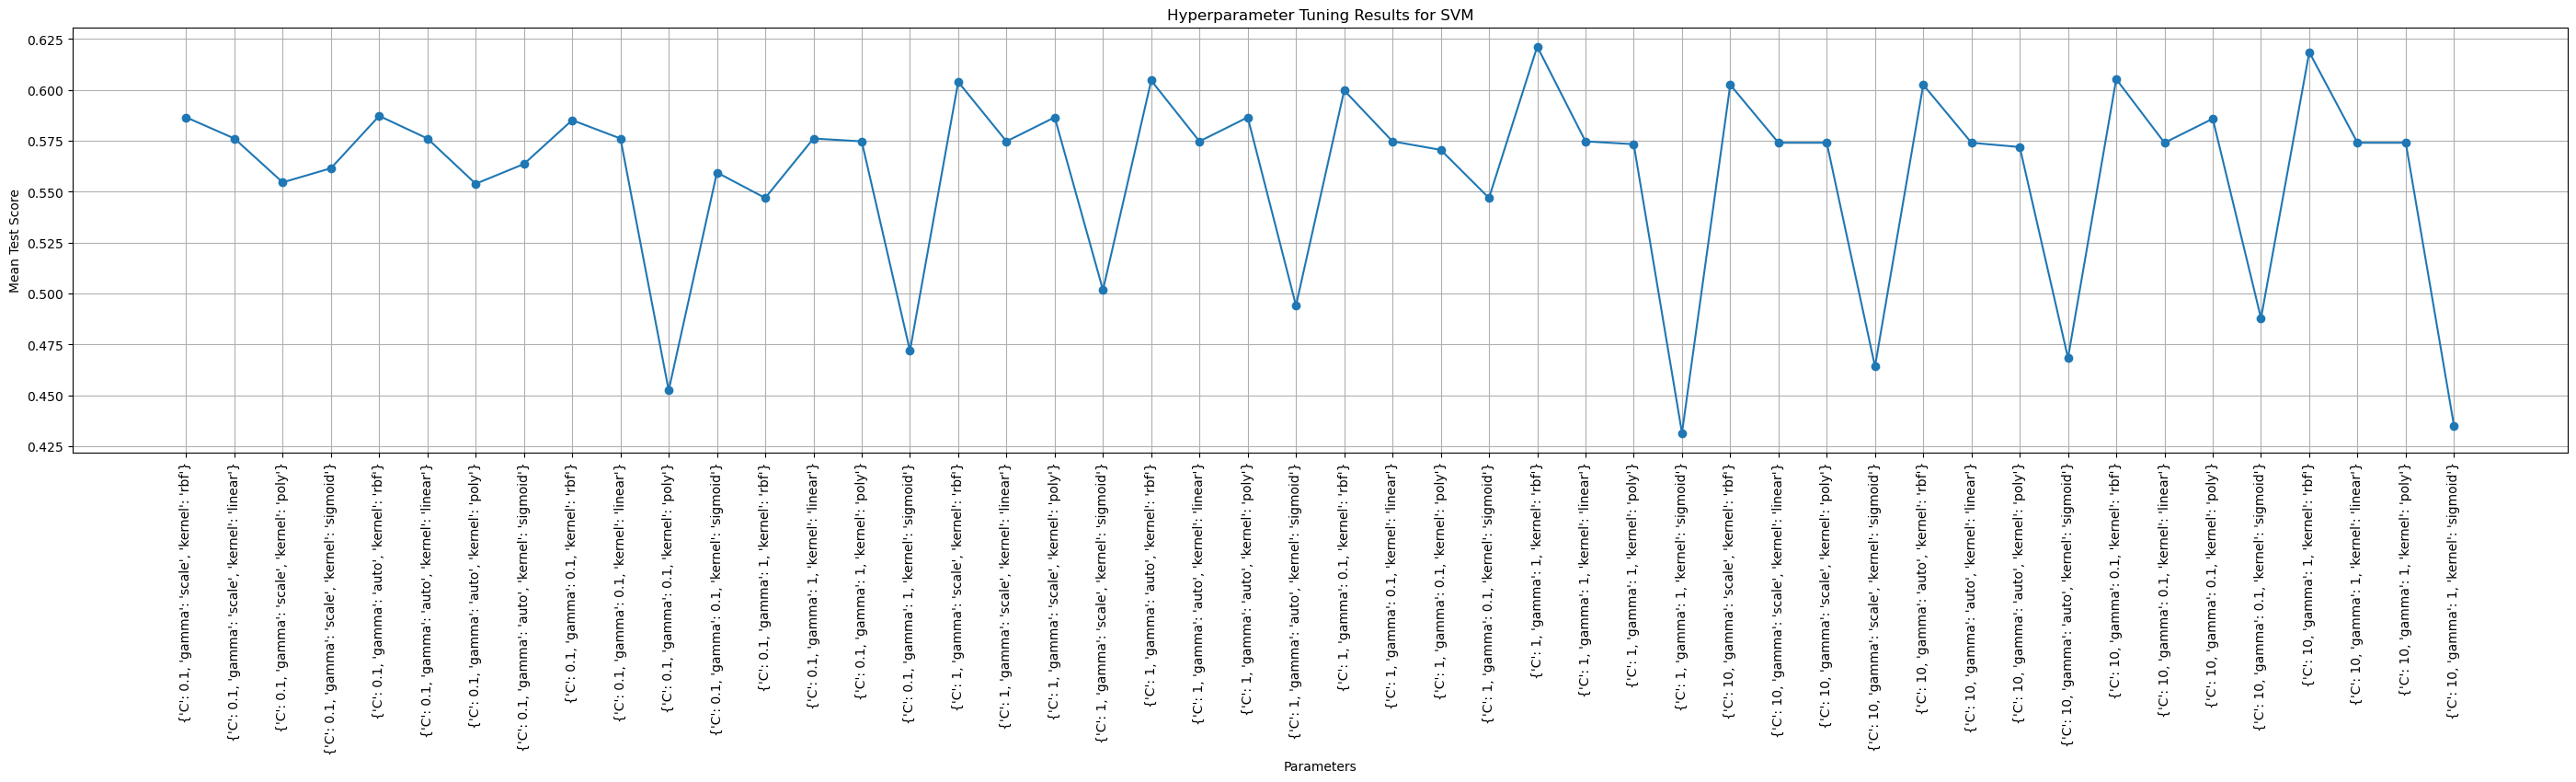

Training completed in 0.0947 seconds.
Training Accuracy: 0.7901
Test Accuracy: 0.6000
Final test accuracy: 0.6000


In [7]:
full_process('processed_wine_quality_pca.csv', 'SVM','pca')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


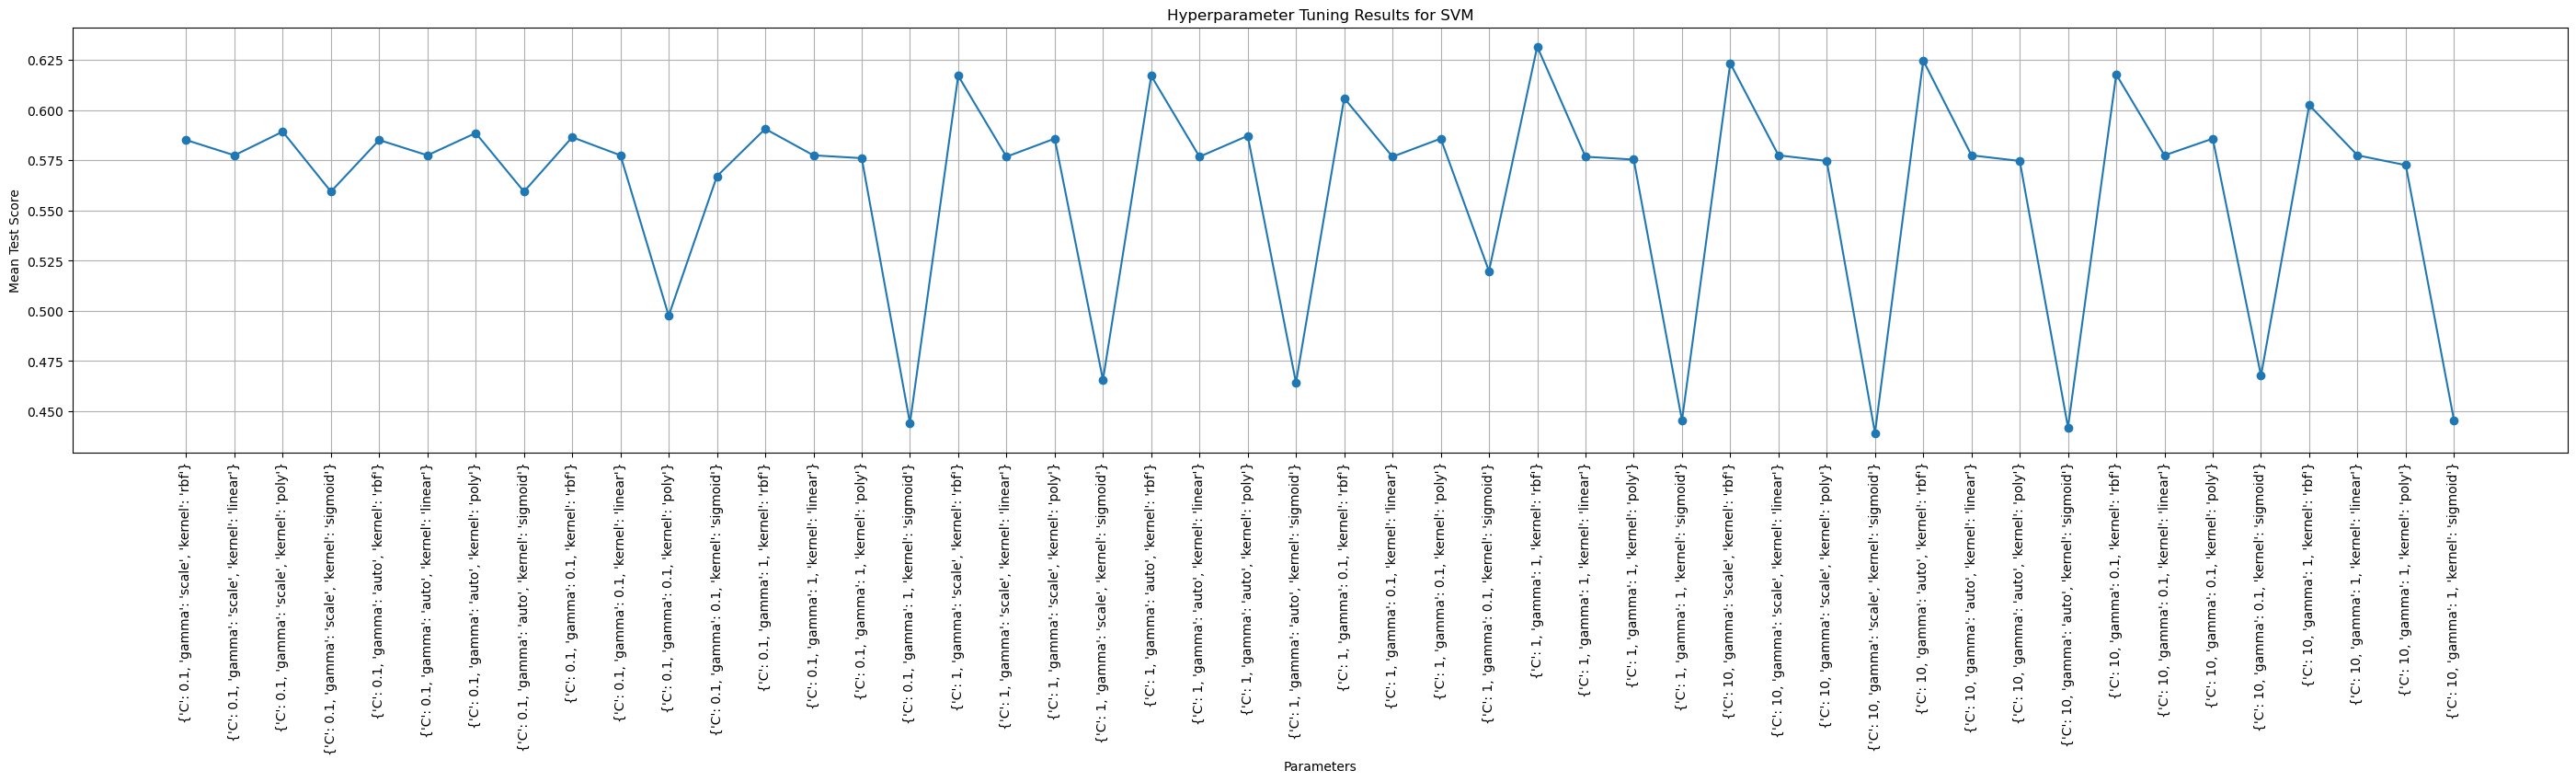

Training completed in 0.0794 seconds.
Training Accuracy: 0.7443
Test Accuracy: 0.5938
Final test accuracy: 0.5938


In [8]:
full_process('processed_wine_quality_feature_selected.csv', 'SVM','feature_selected')